# Analyse et classifiactions des sentiments des 1000 meilleurs films selon IMDB 

2. Analyse des sentiments
3. classification des sentiments (Machine Learning & Deep learning )

In [ ]:
# library 
import os  
import re 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk


from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report 

from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.problem_transform import BinaryRelevance

from pathlib import Path
sns.set_theme(style="whitegrid", palette="pastel")
from matplotlib import rcParams

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [53]:
BASE_DIR = Path().resolve().parent
DATA_DIR = BASE_DIR / 'Data' 

# import des données 
df = pd.read_csv(DATA_DIR / 'Top_1000_IMDb_movies.csv')
df.head(3)

,Unnamed: 0,Movie Name,Year of Release,Watch Time,Movie Rating,Metascore of movie,Gross,Votes,Description
0,0,The Shawshank Redemption,1994,142,9.3,82.0,28.34,"27,77,378","Over the course of several years, two convicts..."
1,1,The Godfather,1972,175,9.2,100.0,134.97,"19,33,588","Don Vito Corleone, head of a mafia family, dec..."
2,2,The Dark Knight,2008,152,9.0,84.0,534.86,"27,54,087",When the menace known as the Joker wreaks havo...


In [54]:
print(f"la database contient {df.shape[0]} lignes et {df.shape[1]} colonnes")
print(f"les colonnes sont : {df.columns.tolist()}")

la database contient 1000 lignes et 9 colonnes
les colonnes sont : ['Unnamed: 0', 'Movie Name', 'Year of Release', 'Watch Time', 'Movie Rating', 'Metascore of movie', 'Gross', 'Votes', 'Description']


**Nettoyage et traitement des données**

In [55]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['unnamed:_0', 'movie_name', 'year_of_release', 'watch_time',
       'movie_rating', 'metascore_of_movie', 'gross', 'votes', 'description'],
      dtype='object')

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   unnamed:_0          1000 non-null   int64  
 1   movie_name          1000 non-null   object 
 2   year_of_release     1000 non-null   object 
 3   watch_time          1000 non-null   int64  
 4   movie_rating        1000 non-null   float64
 5   metascore_of_movie  845 non-null    float64
 6   gross               838 non-null    object 
 7   votes               1000 non-null   object 
 8   description         1000 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 70.4+ KB


In [57]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
# df['compound_score'] = df['Description'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['compound_score'] = df['description'].fillna('').apply(lambda x: sia.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\NAZIFOU\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [58]:
df['compound_score']

0      0.7096
1      0.2732
2     -0.8176
3     -0.5994
4     -0.8405
        ...  
995   -0.4588
996   -0.6808
997    0.5806
998   -0.8909
999   -0.9485
Name: compound_score, Length: 1000, dtype: float64

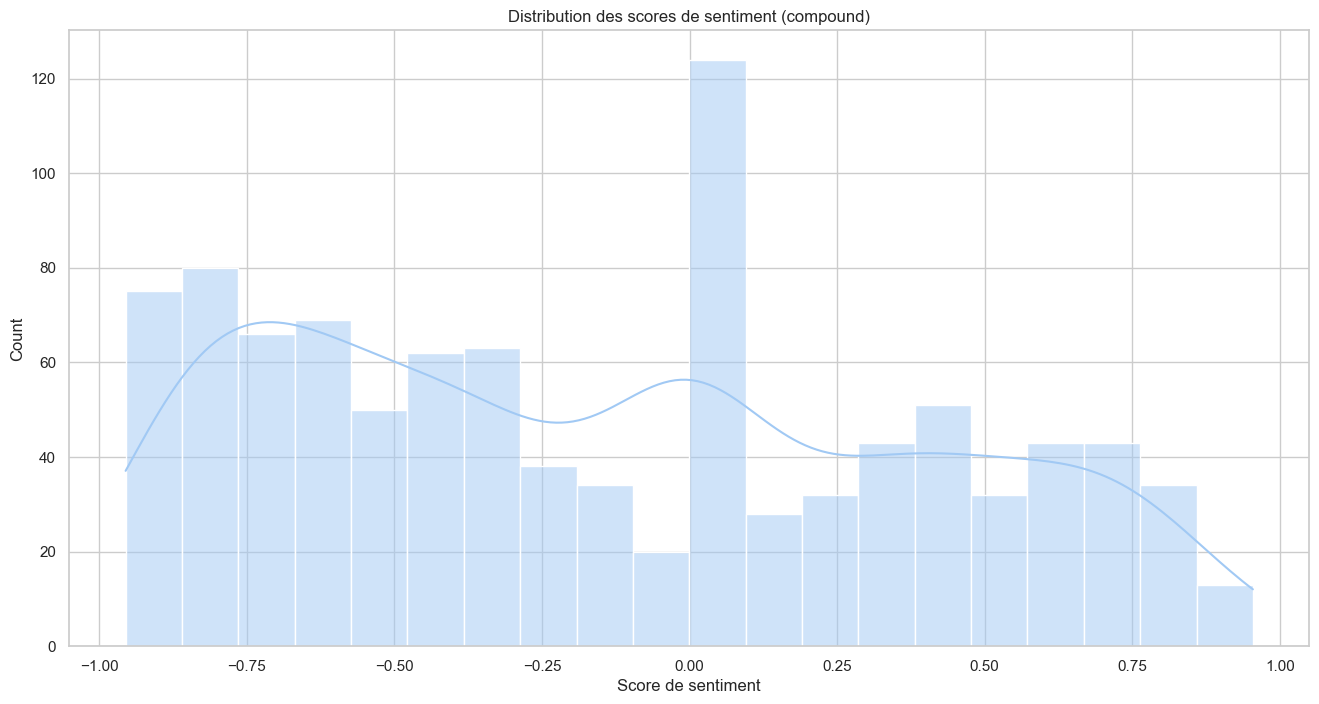

In [61]:
# Visualisation de la distribution des scores de sentiment
plt.figure(figsize=(16, 8))
sns.histplot(df['compound_score'], bins=20, kde=True)
plt.title("Distribution des scores de sentiment (compound)")
plt.xlabel("Score de sentiment")
plt.show()

Le score compound de VADER varie de -1 (négatif) à 1 (positif) :

- Une concentration importante autour de 0 : beaucoup de textes semblent neutres.
- Asymétrie légèrement marquée côté négatif : plus de textes avec des scores vers -0.75.
- Des textes positifs existent aussi, mais moins fréquents que les négatifs.

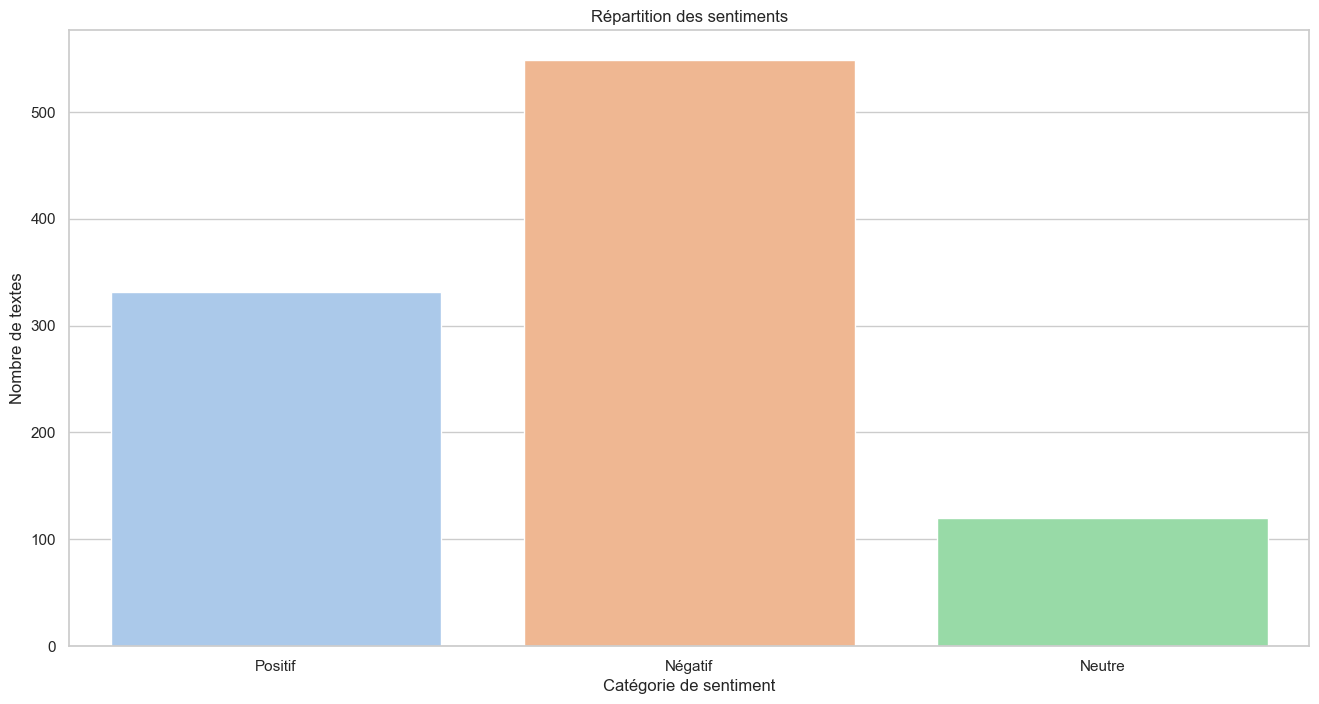

In [64]:
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positif'
    elif score <= -0.05:
        return 'Négatif'
    else:
        return 'Neutre'

df['sentiment'] = df['compound_score'].apply(categorize_sentiment)

plt.figure(figsize=(16, 8))
sns.countplot(x='sentiment', data=df, palette='pastel')
plt.title("Répartition des sentiments")
plt.xlabel("Catégorie de sentiment")
plt.ylabel("Nombre de textes")
plt.show()

 Interprétation
 
Négatif domine largement les textes ➜ > 500 cas.

Positif vient ensuite avec environ 330 textes.

Neutre est très minoritaire (~120), ce qui est souvent le cas si le seuil de neutralité est serré (entre -0.05 et 0.05).



## **Analyse des sentiments**

In [ ]:
# Supprimer les mots vides 
stop_words = set(stopwords.words('english'))


#fonction pour supprimer les mots vides
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

# nettoyer le texte
def clean_text(text):
    # Convertir en minuscules
    text = text.lower()
    # Supprimer les caractères spéciaux et les chiffres
    text = re.sub(r'[^a-z\s]', '', text)
    # Supprimer les mots vides
    text = remove_stopwords(text)
    return text

#stemming 
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
df['Description'] = df['Description'].astype(str)
df['Description'] = df['Description'].apply(lambda x: remove_stopwords(x))
df['Description'] = df['Description'].apply(lambda x:clean_text(x))
df['Description'] = df['Description'].apply(stemming)



#### **VADER Analyse des sentiments :**

In [66]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialisation de l'analyseur de sentiments VADER
sia = SentimentIntensityAnalyzer()

# Calculer les scores de sentiment
df['VADER_Sentiment'] = df['description'].apply(lambda text: sia.polarity_scores(text)['compound'])

# Catégoriser le sentimen
df['VADER_Sentiment_Label'] = df['VADER_Sentiment'].apply(lambda score: 'Positive' if score > 0 else ('Negative' if score < 0 else 'Neutral'))

# Exemples de résultats
print(df[['description', 'VADER_Sentiment_Label']].sample(10))

                                           description VADER_Sentiment_Label
898  In 1990, to protect his fragile mother from a ...              Negative
330  In the rural heartlands of India, an upright p...              Negative
499  The X-Men send Wolverine to the past in a desp...              Negative
470  Story of 40-man Turkish task force who must de...               Neutral
70   The Avengers and their allies must be willing ...              Negative
895  Two parallel stories about two identical women...               Neutral
604  A mysterious Hollywood action film stuntman ge...              Negative
423  Found inside a shining stalk of bamboo by an o...              Negative
847  A day in the lives of two convenience clerks n...              Negative
113  Despite being caught in her imaginative world,...              Positive


Observation rapide

| Label    | Nombre dans l’échantillon  |
|----------|----------------------------|
| Negative | 7                          |
| Neutral  | 2                          |
| Positive | 1                          |


- Descriptions plutôt longues, issues probablement de résumés de films ou de produits culturels.

- VADER semble assez sévère, penchant vers le négatif, même pour des phrases qui, hors contexte, paraissent neutres ou épiques.

Cela peut être dû à :
- Un vocabulaire dramatique (souffrance, guerre, peur, danger, désespoir...) qui est perçu négativement.
- Le manque de contexte émotionnel explicite (VADER est basé sur des mots clés, pas de contexte narratif profond).



### **Machine Learning avec des caractéristiques textuelles**

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Diviser l'ensemble de données en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(df['description'], df['VADER_Sentiment_Label'], test_size=0.2, random_state=42)

# Créer un vecteur TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Entraînement d'un classificateur Naive Bayes
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tfidf, y_train)

# Prédire les étiquettes de sentiment
y_pred = naive_bayes_classifier.predict(X_test_tfidf)


# afficher le rapport de classification
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

              precision    recall  f1-score   support

    Negative       0.56      1.00      0.71       110
     Neutral       0.00      0.00      0.00        15
    Positive       1.00      0.03      0.05        75

    accuracy                           0.56       200
   macro avg       0.52      0.34      0.26       200
weighted avg       0.68      0.56      0.41       200

Accuracy: 0.56


c:\Users\NAZIFOU\Sentiment-Analysis-Top_1000_IMDb_movies\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\NAZIFOU\Sentiment-Analysis-Top_1000_IMDb_movies\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\NAZIFOU\Sentiment-Analysis-Top_1000_IMDb_movies\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

| Sentiment       | Precision | Recall | F1-score | Support |
|----------------:|-----------|--------|----------|---------|
| Negative        | 0.56      | 1.00   | 0.71     | 110     |
| Neutral         | 0.00      | 0.00   | 0.00     | 15      |
| Positive        | 1.00      | 0.03   | 0.05     | 75      |
|                 |           |        |          |         |
| **Accuracy**    |           |        | **0.56** | 200     |
| **Macro avg**   | 0.52      | 0.34   | 0.26     | 200     |
| **Weighted avg**| 0.68      | 0.56   | 0.41     | 200     |


**Interprétation**

**Classe "Negative" :**
- Très bien détectée par le modèle (recall = 1.00), mais précision modérée (0.56), donc quelques faux positifs.
- Ce qui suggère que le modèle prévoit presque tout comme "Negative", par facilité.

**Classe "Neutral" :**
- Score catastrophique : aucun texte neutre n’a été correctement prédit.
- Cela peut venir du déséquilibre de classes (seulement 15 exemples), ou de caractéristiques peu discriminantes pour cette classe.

**Classe "Positive" :**
- Très bonne précision (1.00), ce qui veut dire que les rares prédictions "Positive" étaient correctes.
- Mais recall très faible (0.03), donc le modèle ne détecte presque aucun texte positif.

**Accuracy globale = 56% :**
- En apparence correcte, mais fortement biaisée par la prédiction majoritaire "Negative".

**Macro avg = très faible (0.26 de f1) :**
- Indique que le modèle n’est pas équilibré sur les trois classes.

## **Deep Learning avec LSTM (mémoire à long terme) :**